In [18]:
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import re

import pickle

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
#import utils

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from sklearn.pipeline import Pipeline

from scipy.special import softmax

import pylab as pl

#import tensorflow as tf

from collections import Counter

import time

import random

## Text importing & cleaning function

In [2]:
cd Wiki_comment_comp/

/home/ubuntu/Wiki_comment_comp


In [3]:
jigsaw_train_data = pd.read_csv('train.csv.zip')
jigsaw_test_data = pd.read_csv('test.csv.zip')
jigsaw_test_label_data = pd.read_csv('test_labels.csv.zip')

binary_df = jigsaw_train_data[['comment_text','toxic']]

def cleanText(samples):
    text = re.sub(r"\n", " ", samples)
    text = re.sub(r"'", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    words = word_tokenize(text)
    words_ls = []
    for word in words:
        word = re.sub(r'([a-z])\1+', '',word)
        words_ls.append(word)
    words = [w for w in words_ls if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    return words

In [4]:
## Merge the test content and labels
jigsaw_test_consol_data = pd.merge(jigsaw_test_data, jigsaw_test_label_data,
                           left_on = 'id',
                           right_on = 'id')

## take out the unlabelled data
jigsaw_test_consol_data = jigsaw_test_consol_data[jigsaw_test_consol_data.toxic != -1]

## BoW approach

good bow ref - https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
## Vectorize as Bow using processed text

## CountVectorizer converts a collection of text documents to a matrix of token counts
## If you do not provide an a-priori dictionary and you do not use an analyzer that does 
## some kind of feature selection then the number of features will be equal to the vocabulary 
## size found by analyzing the data.

## fit_transform learns the vocabulary dictionary and returns a document-term matrix.

def dummy(doc):
    return doc

cv = CountVectorizer(preprocessor=dummy,
                    analyzer=cleanText,
                    max_features=10000)


X_bow = cv.fit_transform(binary_df['comment_text'])
X_bow_array = X_bow.toarray()

In [81]:
indices = np.arange(X_bow_array.shape[0])
np.random.shuffle(indices)
X_bow_data = X_bow_array[indices]
Y_bow = binary_df['toxic'][indices]

In [25]:
training_samples = 125000

x_train = X_bow_data[:training_samples]
y_train = Y_bow[:training_samples]
x_val = X_bow_data[training_samples: X_bow_array.shape[0]]
y_val = Y_bow[training_samples: X_bow_array.shape[0]]

print('You have % training samples', training_samples)
print('You have & validation samples', X_bow_array.shape[0] - training_samples)

NameError: name 'X_bow_data' is not defined

Fit and assess model

In [83]:
toxic_detect_model = MultinomialNB().fit(x_train, y_train)
train_preds = toxic_detect_model.predict(x_train)
val_preds = toxic_detect_model.predict(x_val)

## Assess validation data set results
labels = [0,1]
print (classification_report(y_val, val_preds))
print(confusion_matrix(y_val, val_preds, labels))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     31254
           1       0.73      0.71      0.72      3317

    accuracy                           0.95     34571
   macro avg       0.85      0.84      0.85     34571
weighted avg       0.95      0.95      0.95     34571

[[30389   865]
 [  967  2350]]


/home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [84]:
pos_array = np.empty([0, 2], dtype=int)
neg_array = np.empty([0, 2], dtype=int)

for i, label in binary_df['toxic'].iteritems():
    entry = []
    entry.append(i)
    entry.append(label)
    if label == 0:
        pos_array = np.append(pos_array, [entry], axis=0)
    else:
        neg_array = np.append(neg_array, [entry], axis=0)
        
number_of_rows = pos_array.shape[0]
random_indices = np.random.choice(number_of_rows, size=60000, replace=False)
random_rows = pos_array[random_indices, :]

y_bow_adj = np.concatenate((neg_array, random_rows), axis=0)

In [85]:
indices = y_bow_adj[:,0]
np.random.shuffle(indices)
X_bow_data = X_bow_array[indices]
Y_bow = binary_df['toxic'][indices]

In [92]:
training_samples = 60000

x_train = X_bow_data[:training_samples]
y_train = Y_bow[:training_samples]
x_val = X_bow_data[training_samples: indices.shape[0]]
y_val = Y_bow[training_samples: indices.shape[0]]

print('You have % training samples', training_samples)
print('You have & validation samples', indices.shape[0] - training_samples)

You have % training samples 60000
You have & validation samples 15294


In [89]:
toxic_detect_model = MultinomialNB().fit(x_train, y_train)
train_preds = toxic_detect_model.predict(x_train)
val_preds = toxic_detect_model.predict(x_val)

## Assess validation data set results
labels = [0,1]
print (classification_report(y_val, val_preds))
print(confusion_matrix(y_val, val_preds, labels))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     12158
           1       0.82      0.76      0.79      3136

    accuracy                           0.92     15294
   macro avg       0.88      0.86      0.87     15294
weighted avg       0.92      0.92      0.92     15294

[[11632   526]
 [  740  2396]]


/home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [91]:
from sklearn.metrics import plot_roc_curve

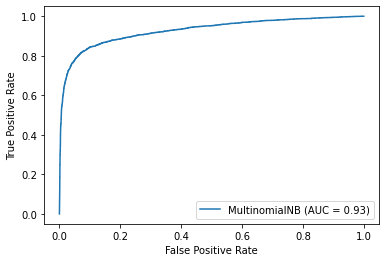

In [94]:
svc_disp = plot_roc_curve(toxic_detect_model, x_val, y_val)

## TF-IDF approach

In [6]:
## Vectorize as TF-IDF using processed text

def dummy(doc):
    return doc

tfidf_transformer = TfidfVectorizer(preprocessor=dummy,
                    analyzer=cleanText)

X_train_tfidf = tfidf_transformer.fit_transform(binary_df['comment_text'])

In [8]:
pos_array = np.empty([0, 2], dtype=int)
neg_array = np.empty([0, 2], dtype=int)

for i, label in binary_df['toxic'].iteritems():
    entry = []
    entry.append(i)
    entry.append(label)
    if label == 0:
        pos_array = np.append(pos_array, [entry], axis=0)
    else:
        neg_array = np.append(neg_array, [entry], axis=0)
        
number_of_rows = pos_array.shape[0]
random_indices = np.random.choice(number_of_rows, size=60000, replace=False)
random_rows = pos_array[random_indices, :]

y_bow_adj = np.concatenate((neg_array, random_rows), axis=0)

In [10]:
indices = y_bow_adj[:,0]
np.random.shuffle(indices)
X_train_tfidf = X_train_tfidf[indices]
Y_bow = binary_df['toxic'][indices]

In [11]:
training_samples = 60000

x_train_tfidf = X_train_tfidf[:training_samples]
y_train_tfidf = Y_bow[:training_samples]
x_val_tfidf = X_train_tfidf[training_samples: X_train_tfidf.shape[0]]
y_val_tfidf = Y_bow[training_samples: X_train_tfidf.shape[0]]

print('You have % training samples', training_samples)
print('You have & validation samples', X_train_tfidf.shape[0] - training_samples)

You have % training samples 60000
You have & validation samples 15294


Fit and assess model

In [13]:
toxic_detect_tfidf_model = MultinomialNB().fit(x_train_tfidf, y_train_tfidf)
train_tfidf_preds = toxic_detect_tfidf_model.predict(x_train_tfidf)
val_tfidf_preds = toxic_detect_tfidf_model.predict(x_val_tfidf)

labels = [0,1]
print (classification_report(y_val_tfidf, val_tfidf_preds))
print(confusion_matrix(y_val_tfidf, val_tfidf_preds, labels))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     12185
           1       0.99      0.33      0.49      3109

    accuracy                           0.86     15294
   macro avg       0.92      0.66      0.71     15294
weighted avg       0.88      0.86      0.83     15294

[[12170    15]
 [ 2084  1025]]


/home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [17]:
toxic_detect_model_dt = DecisionTreeClassifier()
toxic_detect_model_dt = toxic_detect_model_dt.fit(x_train_tfidf, y_train_tfidf)
train_tfidf_preds_dt = toxic_detect_model_dt.predict(x_train_tfidf)
val_tfidf_preds_dt = toxic_detect_model_dt.predict(x_val_tfidf)

labels = [0,1]
print (classification_report(y_val_tfidf, val_tfidf_preds_dt))
print(confusion_matrix(y_val_tfidf, val_tfidf_preds_dt, labels))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12185
           1       0.77      0.75      0.76      3109

    accuracy                           0.90     15294
   macro avg       0.86      0.85      0.85     15294
weighted avg       0.90      0.90      0.90     15294

[[11504   681]
 [  773  2336]]


Try different model approaches

In [22]:
toxic_detect_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
toxic_detect_ada = toxic_detect_ada.fit(x_train_tfidf, y_train_tfidf)

In [24]:
train_tfidf_preds_ada = toxic_detect_ada.predict(x_train_tfidf)
val_tfidf_preds_ada = toxic_detect_ada.predict(x_val_tfidf)

labels = [0,1]
print (classification_report(y_val_tfidf, val_tfidf_preds_ada))
print(confusion_matrix(y_val_tfidf, val_tfidf_preds_ada, labels))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12185
           1       0.88      0.67      0.76      3109

    accuracy                           0.91     15294
   macro avg       0.90      0.82      0.86     15294
weighted avg       0.91      0.91      0.91     15294

[[11903   282]
 [ 1020  2089]]


/home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
